In [1]:
%reset
%pylab inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')

In [3]:
from utils import loadmat
import brewer2mpl
from __future__ import division
import os
import pandas as pd
import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.transforms import blended_transform_factory

In [4]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
reconlist = os.path.join(SJdir, 'PCA', 'reconlist_pruned.csv')
reconlist = pd.read_csv(reconlist)

In [5]:
filename = os.path.join(SJdir,'PCA', 'RTs','RT_summary_offsets.csv')
dfRT = pd.read_csv(filename)

In [8]:
dfRT.loc[(dfRT.task == 'DecisionVis')]

,Unnamed: 0,subj,task,RTs_mean,RTs_std,RTs_range,RTs_skew
33,33,ST27,DecisionVis,396.276029,193.294876,1053.0,0.535507
34,34,ST28,DecisionVis,556.414226,423.002771,1795.0,1.073852
35,35,ST32,DecisionVis,134.743590,116.957069,698.0,0.922198


In [9]:
dfRT.loc[(dfRT.task == 'DecisionVis'),'RTs_mean'] += 500  #adjust so start from cue offset
dfRT.loc[(dfRT.task == 'DecisionAud'),'RTs_mean'] += 600 

In [10]:
tmp = dfRT.groupby('task').mean().sort_values(by='RTs_mean')
tmp['RTs_mean']

task
FaceGen         326.972271
FaceEmo         343.521582
EmoRep          450.391355
DecisionVis     862.477948
SelfAud        1005.175139
SelfVis        1060.270927
EmoGen         1408.861925
DecisionAud    1570.304267
Name: RTs_mean, dtype: float64

In [27]:
stim_dur_dict = {'DecisionAud':600, 'DecisionVis':500, 'FaceEmo':300, 'FaceGen':300, 'SelfVis':400}

dfall = pd.DataFrame()
df = pd.DataFrame()
for x in reconlist.values:
    subj_task, recon, _,srate, _ = x

    if (isinstance(recon, float)): #no recon
        continue
        
    subj, task = subj_task.split('_')

    #load onsets_stim and onsets_resp
    filenames = glob.glob(os.path.join(SJdir, 'Subjs', subj, task, 'onsets*.mat'))
    filenames = [s for s in filenames if 'empty' not in s]
    
    data_dict = dict()
    for f in filenames:
        data_dict.update(loadmat.loadmat(f))
        
    varnames = [x.split('/')[-1].split('.')[0] for x in filenames]
    varnames.remove('onsets_cue') if 'onsets_cue' in varnames else 1 #drop onsets_cue for my data
    
    #assign onsets_stim and _resp to correct variables (hacky because of weird naming structure in orig data)
    idx = ['resp' in x for x in varnames]
    idx_resp = [i for i, elem in enumerate(idx) if elem][0]
    idx_stim = [i for i, elem in enumerate(idx) if not(elem)][0]
    
    tmp = [data_dict.get(k) for k in varnames]
    onsets_resp = tmp[idx_resp]
    onsets_stim = tmp[idx_stim]
    
    RTs = onsets_resp - onsets_stim
    goodidx = (RTs > (RTs.mean() - 3 * RTs.std())) & (RTs < RTs.mean() + 3 * RTs.std())
    onsets_resp = onsets_resp[goodidx]
    onsets_stim = onsets_stim[goodidx]
        
    onsets_resp = onsets_resp/srate*1000
    onsets_stim = onsets_stim/srate*1000
    
    RTs = onsets_resp - onsets_stim

    
    #load stimulus duration for auditory tasks with variable durations
#     if (task == 'SelfAud') | (task == 'EmoRep') | (task == 'EmoGen'):
#         filename = os.path.join(SJdir, 'Subjs', subj, task, 'stim_dur.mat')
#         data_dict = loadmat.loadmat(filename)
#         stim_dur = data_dict['stim_dur']
#         stim_dur = stim_dur[goodidx]
#     else:
#         stim_dur = np.tile(stim_dur_dict[task], onsets_stim.size)

    #for offsets?
    #RT_offsets = onsets_resp - (onsets_stim + stim_dur) (unnecessary)
    #RT_offsets = onsets_resp - onsets_stim
    #df = pd.DataFrame({'subj': np.tile(subj, RT_offsets.shape), 'task':np.tile(task, RT_offsets.shape), 'RTs':RT_offsets})
    df = pd.DataFrame({'subj': np.tile(subj, RTs.shape), 'task':np.tile(task, RTs.shape), 'RTs':RTs})
    dfall = dfall.append(df)

In [25]:
np.unique(dfall.subj)

array(['CP7', 'CP9', 'GP15', 'GP28', 'GP35', 'JH10', 'JH17', 'JH2', 'JH5',
       'JH6', 'ST1', 'ST15', 'ST27', 'ST32', 'ST4', 'ST6'], dtype=object)

In [36]:
dfall.groupby(['task', 'subj']).mean().reset_index().groupby('task').mean().sort_values(by = "RTs")

,RTs
task,
FaceGen,626.972271
FaceEmo,643.521582
DecisionVis,765.509809
EmoRep,1117.721343
SelfVis,1460.270927
DecisionAud,1554.727233
SelfAud,1719.787672
EmoGen,2050.255265


In [37]:
#create dataframe
RTs_n = list(); RTs_mean = list(); RTs_std = list(); RTs_range = list(); RTs_skew = list(); subjs = list(); tasks = list()

for r in dfall.groupby(['subj','task']):
    s, t = r[0]
    RTs = r[1]['RTs']
    RTs_mean.append(RTs.mean())
    RTs_std.append(RTs.std())
    #RTs_range.append((max(RTs)-min(RTs)))
    #RTs_skew.append(stats.kurtosis(RTs))
    #RTs_n.append(len(RTs))
    subjs.append(s)
    tasks.append(t)

df = pd.DataFrame()
df['subj'] = subjs
df['task'] = tasks
df['RTs_mean'] = RTs_mean
df['RTs_std'] = RTs_std
#df['RTs_range'] = RTs_range
#df['RTs_skew'] = RTs_skew

tmp = df.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


task
FaceGen         626.972271
FaceEmo         643.521582
DecisionVis     765.509809
EmoRep         1117.721343
SelfVis        1460.270927
DecisionAud    1554.727233
SelfAud        1719.787672
EmoGen         2050.255265
Name: RTs_mean, dtype: float64

In [39]:
df.groupby('task').count().subj

task
DecisionAud     2
DecisionVis     2
EmoGen          4
EmoRep          8
FaceEmo         4
FaceGen         2
SelfAud        10
SelfVis         5
Name: subj, dtype: int64

In [40]:
len(df.groupby('subj').count().index)

16

In [41]:
#num_tasks = len(df.groupby('task').count().index)
num_tasks = tmp.shape[0]
num_tasks

8

In [42]:
names_dict = {'DecisionAud' : 'Auditory\nCategorization', \
              'DecisionVis' : 'Visual\nCategorization', \
             'EmoGen' : 'Antonym\nGeneration', \
             'EmoRep' : 'Word\nRepetition', \
             'FaceEmo' :'Face Emotion\nCategorization', \
             'FaceGen' : 'Face Gender\nCategorization', \
             'SelfAud' : 'Auditory\nSelf Referential\nCategorization', \
             'SelfVis' : 'Visual\nSelf Referential\nCategorization'}

In [43]:
df.groupby('task').mean().sort_values(by='RTs_mean')

,RTs_mean,RTs_std
task,,
FaceGen,626.972271,151.343235
FaceEmo,643.521582,145.209711
DecisionVis,765.509809,155.125973
EmoRep,1117.721343,170.059465
SelfVis,1460.270927,429.425367
DecisionAud,1554.727233,371.394245
SelfAud,1719.787672,535.030884
EmoGen,2050.255265,703.313947


In [122]:
SJdir

'/home/knight/matar/MATLAB/DATA/Avgusta/'

In [46]:
tmp.index

Index([u'FaceGen', u'FaceEmo', u'DecisionVis', u'EmoRep', u'SelfVis',
       u'DecisionAud', u'SelfAud', u'EmoGen'],
      dtype='object', name=u'task')

In [53]:
dfall.groupby(['subj','task']).mean().reset_index().groupby('task').mean().sort_values(by = 'RTs')

,RTs
task,
FaceGen,626.972271
FaceEmo,643.521582
DecisionVis,765.509809
EmoRep,1117.721343
SelfVis,1460.270927
DecisionAud,1554.727233
SelfAud,1719.787672
EmoGen,2050.255265


In [65]:
for s in dfall.loc[dfall['task'] == task].dropna().groupby('subj'):
    s
s[1]['RTs']

0      1973.942906
1      1854.667471
2      2721.708130
3      1831.729888
4      2674.849924
5      3620.533726
6      1486.683095
7      2878.339058
8      3761.108345
9      2155.149816
10     2331.769209
11     1320.877134
12     2958.292920
13     3265.328860
14     3134.912314
15     1565.981598
16     1429.011456
17     1143.602381
18     2930.767820
19     3348.887201
20     2302.933390
21     2547.382495
22     2731.866203
23     3712.939420
24     2634.217633
25     1709.505335
26     1932.080233
27     3836.471548
28     1848.767721
29     2183.779046
          ...     
103    2708.844480
104    3081.047429
105    3095.055727
106    1571.305107
107    1789.908291
108    3172.388088
109    4096.976748
110    3388.861356
111    1980.740638
112    4171.892473
113    4605.822047
114    1660.147211
115    4308.657703
116    4122.371909
117    2016.990183
118    1785.402698
119    1492.129549
120    3246.812294
121    1863.759058
122    2019.079139
123    2469.351728
124    2433.

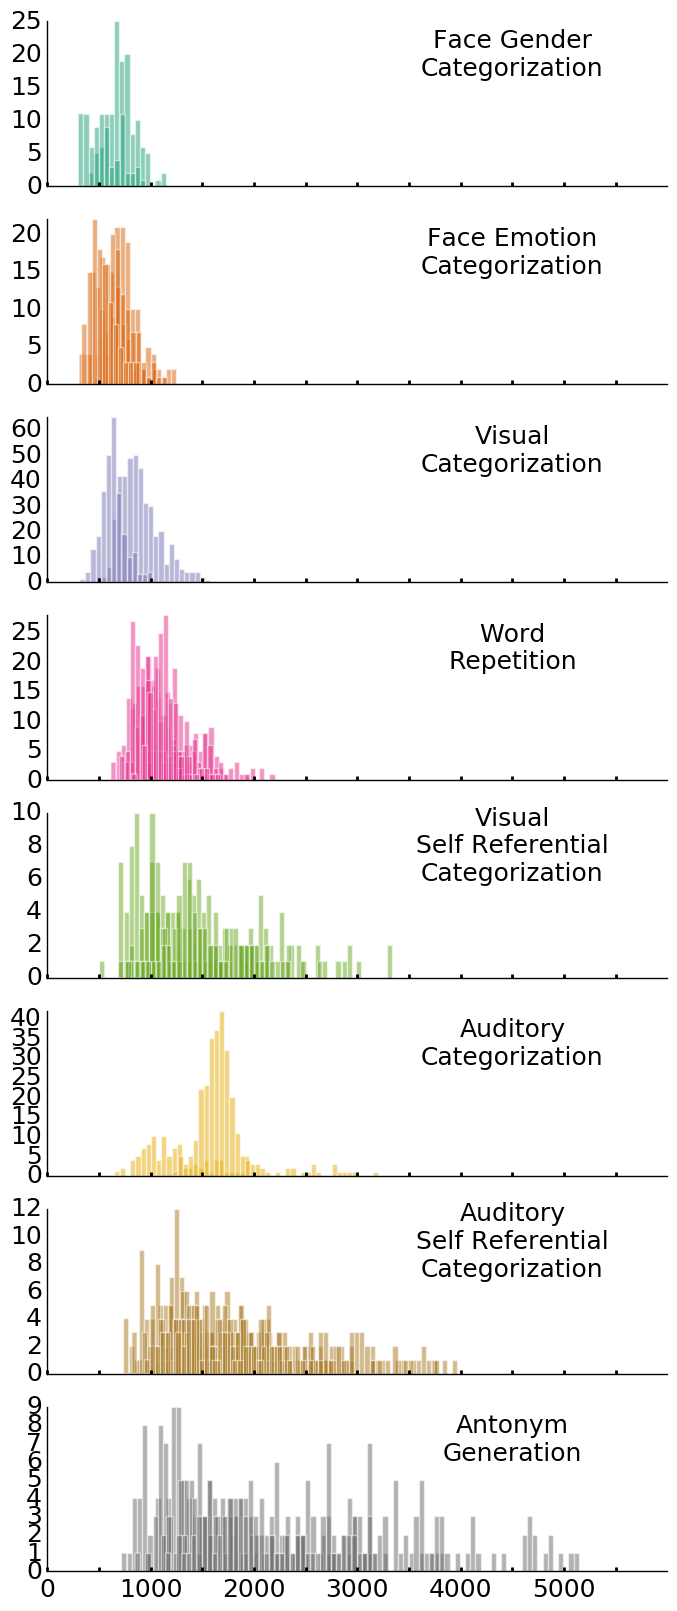

In [70]:
set2 = brewer2mpl.get_map('Dark2', 'Qualitative', num_tasks).mpl_colors
fig, ax = plt.subplots(num_tasks, sharex=True, figsize = (8, 20), subplot_kw=dict(axisbg='#EEEEEE'))
plt.tight_layout

left, width = .25, .75
bottom, height = .25, .70
right = left + width
top = bottom + height


for i, t in enumerate(tmp.index):
    ax[i].patch.set_facecolor('white')
    ax[i].autoscale(tight=True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    ax[i].yaxis.set_tick_params(labelsize = 18, width = 0)
    ax[i].xaxis.set_tick_params(labelsize = 18, width = 0)
    #majorLocator   = MultipleLocator(5)
    #majorFormatter = FormatStrFormatter('%d')
    
    #ax[i].yaxis.set_major_locator(majorLocator)
    #ax[i].yaxis.set_major_formatter(majorFormatter)

#     ax[i].text(right, top, names_dict[t],
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax[i].transAxes, fontsize = 24, weight = 'bold')    
    
    #ax[i].set_ylabel('Trials', fontsize = 24, weight = 'bold')
    
    
for i, task in enumerate(tmp.index): #ordered by increasing mean
    data = dfall.loc[dfall['task'] == task].dropna()
    
    for s in data.groupby('subj'):
        data = s[1]['RTs']
        binwidth = 50
        ax[i].hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), color = set2[i], alpha = 0.5, edgecolor = 'white')
        #x = s[1]['RTs'].hist(ax = ax[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white', label = s[0])
        #x.legend()
        
    ax[i].xaxis.set_tick_params(labelsize = 18, length = 3, width = 2)
    ax[i].set_xlim([0,6000])
    ax[i].set_xticks(np.arange(0, 6000, 500))
    plt.setp(ax[i].get_xticklabels()[1::2], visible=False)

    tform = blended_transform_factory(ax[i].transData, ax[i].transAxes)
    ax[i].annotate(names_dict[task], xy=(3500, 0), xycoords=tform, 
        xytext=(4500, 0.8), textcoords=tform, fontsize=18,
        ha='center', va='center')

#         mn = df.groupby('task').mean().loc[task]['RTs_mean']
#         sd = df.groupby('task').mean().loc[task]['RTs_std']
#         label = 'MN=%.2f\nSD=%.2f' %(mn, sd)
        
                
plt.savefig(os.path.join(SJdir, 'PCA', 'Figures','RT_hists_alpha_withlabel_withticks_20170123.png'), transparent = True)        



In [71]:
SJdir

'/home/knight/matar/MATLAB/DATA/Avgusta/'

# from onset (not used)

In [19]:
dfall = pd.DataFrame()
df = pd.DataFrame()
for x in reconlist.values:
    subj_task, recon, _, _, _ = x
    if (isinstance(recon, float)): #no recon
        continue
    subj, task = subj_task.split('_')

    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_percent.mat')
    data = loadmat.loadmat(filename)
    srate = data['srate']
    RT = data['RTs'].flatten()/srate*1000 #convert to ms
    
    if task == 'DecisionAud': #shift by cue (HGmtx includes cue in RT for plotting)
        RT = RT - 600
    if task == 'DecisionVis':
        RT = RT - 500
    
    df = pd.DataFrame({'subj': np.tile(subj, RT.shape), 'task':np.tile(task, RT.shape), 'RTs':RT})
    dfall = dfall.append(df)

KeyboardInterrupt: 

In [20]:
tmp_n = dfall
tmp_n.drop_duplicates(['subj','task']).groupby('task').count()

,RTs,subj
task,,
EmoGen,4,4
EmoRep,8,8
FaceEmo,4,4
FaceGen,2,2
SelfAud,10,10
SelfVis,5,5


In [21]:
#create dataframe
RTs_n = list(); RTs_mean = list(); RTs_std = list(); RTs_range = list(); RTs_skew = list(); subjs = list(); tasks = list()

for r in dfall.groupby(['subj','task']):
    s, t = r[0]
    RTs = r[1]['RTs']
    RTs_mean.append(RTs.mean())
    RTs_std.append(RTs.std())
    RTs_range.append((max(RTs)-min(RTs)))
    RTs_skew.append(stats.kurtosis(RTs))
    RTs_n.append(len(RTs))
    subjs.append(s)
    tasks.append(t)

df = pd.DataFrame()
df['subj'] = subjs
df['task'] = tasks
df['RTs_mean'] = RTs_mean
df['RTs_std'] = RTs_std
df['RTs_range'] = RTs_range
df['RTs_skew'] = RTs_skew



In [24]:
df

,subj,task,RTs_mean,RTs_std,RTs_range,RTs_skew
0,CP7,DecisionAud,1464.096774,599.955519,2508.0,0.217661
1,CP9,DecisionAud,1645.357692,142.832971,812.0,0.464390
2,GP15,EmoGen,2002.870748,696.685826,2852.0,-0.805875
3,GP15,EmoRep,1003.201754,129.039143,592.0,0.630239
4,GP15,FaceEmo,750.923664,155.035213,755.0,0.749593
5,GP15,FaceGen,717.862595,140.601661,747.0,0.353890
6,GP15,SelfAud,1657.036585,520.818550,2265.0,0.696949
7,GP15,SelfVis,1068.064935,315.981109,1203.0,0.303051
8,GP28,SelfAud,1291.513514,429.634960,1865.0,0.759580
9,GP28,SelfVis,1666.059524,572.704435,2635.0,0.261422


In [22]:
tmp = df.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


task
FaceGen     626.949370
FaceEmo     643.514444
EmoRep     1117.695759
SelfVis    1460.243998
SelfAud    1719.814953
EmoGen     2050.264387
Name: RTs_mean, dtype: float64

In [22]:
tmp = df.groupby('task').mean().sort('RTs_mean')
tmp['RTs_mean']

/srv/local/anaconda-2.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


task
FaceGen         626.949370
FaceEmo         643.514444
DecisionVis     765.509809
EmoRep         1117.695759
SelfVis        1460.243998
DecisionAud    1554.727233
SelfAud        1719.814953
EmoGen         2050.264387
Name: RTs_mean, dtype: float64

In [1]:
set2 = brewer2mpl.get_map('Dark2', 'Qualitative', num_tasks).mpl_colors
fig, ax = plt.subplots(num_tasks,sharex=True, figsize = (8, 20),subplot_kw=dict(axisbg='#EEEEEE'))
plt.tight_layout

left, width = .25, .75
bottom, height = .25, .70
right = left + width
top = bottom + height


for i, t in enumerate(tmp.index):
    ax[i].patch.set_facecolor('white')

    ax[i].autoscale(tight=True)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    ax[i].yaxis.set_tick_params(labelsize = 18, width = 0)
    ax[i].xaxis.set_tick_params(labelsize = 18, width = 0)
    #majorLocator   = MultipleLocator(5)
    #majorFormatter = FormatStrFormatter('%d')
    
    #ax[i].yaxis.set_major_locator(majorLocator)
    #ax[i].yaxis.set_major_formatter(majorFormatter)

#     ax[i].text(right, top, names_dict[t],
#             horizontalalignment='right',
#             verticalalignment='top',
#             transform=ax[i].transAxes, fontsize = 24, weight = 'bold')    
    
    ax[i].set_ylabel('Trials', fontsize = 18)
    
    
for i, task in enumerate(tmp.index): #ordered by increasing mean
    data = dfall.loc[dfall['task'] == task].dropna()
    
    for s in data.groupby('subj'):
        data = s[1]['RTs']
        binwidth = 50
        ax[i].hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), color = set2[i], alpha = 0.5, edgecolor = 'white')
        #x = s[1]['RTs'].hist(ax = ax[i], alpha = 0.5, grid = False, xlabelsize= 20, ylabelsize = 16, edgecolor = 'white', label = s[0])
        #x.legend()
        mn = df.groupby('task').mean().loc[task]['RTs_mean']
        sd = df.groupby('task').mean().loc[task]['RTs_std']
        label = 'MN=%.2f\nSD=%.2f' %(mn, sd)
        
        tform = blended_transform_factory(ax[i].transData, ax[i].transAxes)
        ax[i].annotate(names_dict[task], xy=(3500, 0), xycoords=tform, 
           xytext=(3750, 0.8), textcoords=tform, fontsize=18,
           ha='center', va='center')
        
        #ax[i].annotate(label, xy=(3500, 0), xycoords=tform, 
        #    xytext=(3500, 0.8), textcoords=tform, fontsize=18,
        #    ha='center', va='center')
ax[i].set_xlabel('RTs (ms)', fontsize = 18)      
#plt.savefig(os.path.join(SJdir, 'PCA', 'RTs','RT_hists_alpha_onset_tasklabel.pdf'), transparent = True)        

NameError: name 'brewer2mpl' is not defined